# README

We are analyzing the preFilter algorithm that we have developed in this code. We are looking at the test case of three curves, one curve clearly at a biexponential signal (TI = 0). We are also looking at two other curves of monoexponential character around each null point. We want to see how the result changes with NR so we can choose the minimum number of noise realizations. 

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [2]:
####### Options #######
randStart = True                  #Initial guess for parameter values in random locations

In [3]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12


######### TI list of points used in the final evaluation
TI_DATA = np.array([0, 380, 870])#

#SNR Value to Evaluate
SNR_value = 100

var_reps = 3000

#number of multistarts in the BIC filter to ensure accurate measurement
multi_starts_BIC = 3

if randStart:
    multi_starts_obj = 2
else:
    multi_starts_obj = 1

#number of iterations to evaluate consistency of BIC filter
BIC_eval_iter = 100     

#Builds a string of parameters to use in the titles
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [4]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [5]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

In [6]:
def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_opt2(RSS, TE_array, p_list):

    BIC = len(TE_array) * np.log(RSS/len(TE_array)) + len(p_list) * np.log(len(TE_array))

    return BIC

def evaluate_model(data, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_opt1(RSS_biX, TE_DATA, popt_biX, 1/SNR_value)
    BIC_moX = BIC_opt1(RSS_moX, TE_DATA, popt_moX, 1/SNR_value)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX


In [7]:
def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            if data_2d[iter,0] < 0:
                #first null point -> that means that only the long parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            else:
                #second null point -> that means that only the short parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])

        curve_RSS += RSS_add

    return curve_RSS

def RSS_obj_func(popt, data, TI_val, func):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

In [8]:
def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

# Iterative Fitting

In [9]:
signal_array = np.zeros([len(TI_DATA), len(TE_DATA)])

for iTI in range(len(TI_DATA)):
    signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

In [10]:
param_est_BIC = np.zeros((var_reps, len(true_params)))

param_est_cvn = np.zeros((var_reps, len(true_params)))

param_est_cF = np.zeros((var_reps, len(true_params)))

#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

#Collect the frequency of BIC assessments moX
BIC_moXassessments = np.zeros(len(TI_DATA))

#Building the ravel arrays for the curve_fit comparison
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)

vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points

curve_options = ["BiX", "MoX"] #This implies that a truth for evaluate is moX and a false is biX

print(f"Running {var_reps} noisy realization with {multi_starts_obj} multi start locations for each noisy realization")

for rep in trange(var_reps):

    noised_data = add_noise(signal_array, SNR_value)

    list_curve_BIC = []
    list_curve_cvn = []

    for iter in range(noised_data.shape[0]):
        mox_opt_iter, _, _ = evaluate_model(noised_data[iter,:])
        BIC_moXassessments[iter] += mox_opt_iter
        list_curve_BIC.append(curve_options[mox_opt_iter])
        list_curve_cvn.append(curve_options[0])

    cF_fval = np.inf

    for ms_iter in range(multi_starts_obj):
        init_p = set_p0(S_biX_6p, random = randStart)
        
        try:
            vecS = noised_data.ravel()
            popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
            RSS_cF_array = []
            for iter in range(noised_data.shape[0]):
                RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
            RSS_cF_temp = np.sum(RSS_cF_array)
            if RSS_cF_temp < cF_fval:
                popt = popt_temp
                RSS_cF = RSS_cF_temp
                cF_fval = RSS_cF_temp
        except:
            print("No Optimum found")

    res_BIC = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_BIC), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})
    
    res_cvn = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_cvn), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})

    #Pulling relevant BIC objective function parts
    param_est_BIC[rep,:] = check_param_order(res_BIC.x)

    #Pulling relevant cvn objective function parts
    param_est_cvn[rep,:] = check_param_order(res_cvn.x)

    #Pulling relevant cF objective function parts
    param_est_cF[rep,:] = check_param_order(popt)




Running 3000 noisy realization with 2 multi start locations for each noisy realization


  0%|          | 1/3000 [00:00<16:09,  3.09it/s]

 39%|███▉      | 1167/3000 [04:00<45:51,  1.50s/it]

No Optimum found


 97%|█████████▋| 2896/3000 [09:51<02:33,  1.47s/it]

No Optimum found


100%|██████████| 3000/3000 [10:13<00:00,  4.89it/s]


In [11]:
chop_array = np.arange(10,var_reps,10)

MSE_array = np.zeros((3,len(chop_array)))
var_array = np.zeros((3,len(chop_array)))
bias_array = np.zeros((3,len(chop_array)))

for iRep in range(len(chop_array)):
    MSEMat, varMat, biasMat = calc_MSE(param_est_BIC[:chop_array[iRep]], true_params)
    MSE_array[0, iRep], var_array[0, iRep], bias_array[0, iRep] = [MSEMat[-4], varMat[-4], biasMat[-4]]
    MSEMat, varMat, biasMat = calc_MSE(param_est_cvn[:chop_array[iRep]], true_params)
    MSE_array[1,iRep], var_array[1,iRep], bias_array[1,iRep] = [MSEMat[-4], varMat[-4], biasMat[-4]]
    MSEMat, varMat, biasMat = calc_MSE(param_est_cF[:chop_array[iRep]], true_params)
    MSE_array[2,iRep], var_array[2,iRep], bias_array[2,iRep] = [MSEMat[-4], varMat[-4], biasMat[-4]]

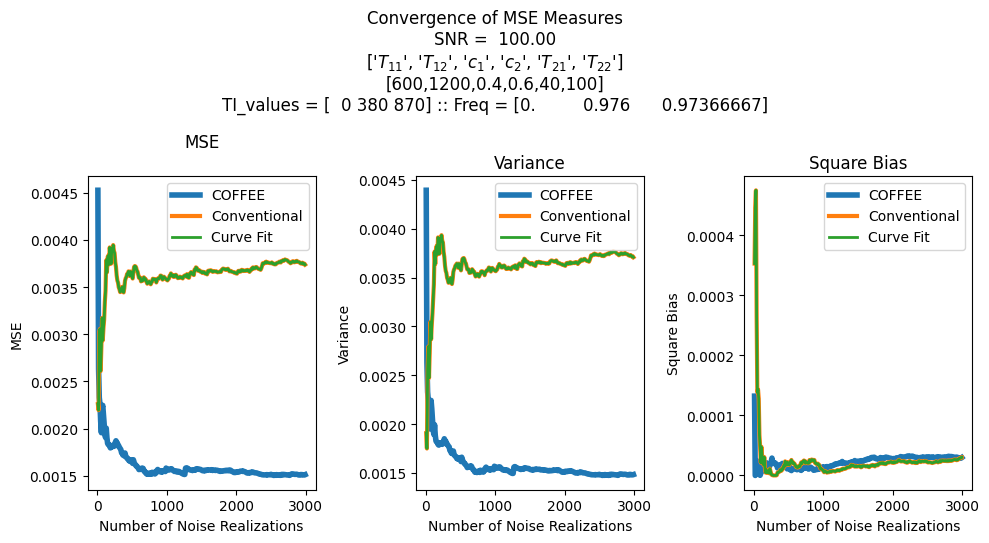

In [12]:
ordering = ["COFFEE", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1,3, figsize=(10,5.5), tight_layout=True)
fig.suptitle(f"Convergence of MSE Measures\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]\nTI_values = {TI_DATA} :: Freq = {BIC_moXassessments/var_reps}")


for iter in range(MSE_array.shape[0]):
    ax[0].plot(chop_array, MSE_array[iter,:], lw = 4-iter, label = f'{ordering[iter]}')
ax[0].set_xlabel('Number of Noise Realizations')
ax[0].set_ylabel('MSE')
ax[0].set_title(f'MSE\n')

ax[0].legend()

for iter in range(MSE_array.shape[0]):
    ax[1].plot(chop_array, var_array[iter,:], lw = 4-iter, label = f'{ordering[iter]}')
ax[1].set_xlabel('Number of Noise Realizations')
ax[1].set_ylabel('Variance')
ax[1].set_title('Variance')

ax[1].legend()

for iter in range(MSE_array.shape[0]):
    ax[2].plot(chop_array, bias_array[iter,:]**2, lw = 4-iter, label = f'{ordering[iter]}')
ax[2].set_xlabel('Number of Noise Realizations')
ax[2].set_ylabel('Square Bias')
ax[2].set_title('Square Bias')

ax[2].legend()